In [94]:
%matplotlib inline
import cPickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
raw_dfs_pk = 'raw_dfs.pickle'

In [3]:
with open(raw_dfs_pk, 'r') as f:
    df_idx, df_sec, df_stk, df_sec_stk_dt = cPickle.load(f)

## 1. 数据质量分析

In [4]:
df_idx.shape, df_sec.shape, df_stk.shape, df_sec_stk_dt.shape

((536, 1), (305, 2), (1400894, 2), (66969, 3))

In [5]:
(len(set(df_idx.index)),
 len(set(df_sec.index)),
 len(set(df_stk.index)),
 len(set(df_sec_stk_dt))
 )

(536, 305, 537, 3)

In [6]:
df_sec.index

DatetimeIndex(['2015-12-15', '2015-12-16', '2015-12-17', '2015-12-18',
               '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24',
               '2015-12-25', '2015-12-28',
               ...
               '2017-03-03', '2017-03-06', '2017-03-07', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16'],
              dtype='datetime64[ns]', name=u'period', length=305, freq=None)

In [7]:
df_sec.dtypes

sec_code      int64
chg_sec     float64
dtype: object

### 该板块从15年12月15日开始指数数据，选择该天作为分析的起始时间

## 2. 减去大盘指数

In [8]:
df_sec.join(df_idx, how='inner').head()

sec_code  chg_sec  chg_idx
period                                 
2015-12-15  400129776   1.9800  -0.4563
2015-12-16  400129776   0.0134  -0.2422
2015-12-17  400129776   2.7270   1.9115
2015-12-18  400129776  -0.2391   0.3202
2015-12-21  400129776  -0.0522   2.6023

In [9]:
df_sec_sub_idx = df_sec.join(df_idx, how='inner')\
    .assign(chg_sec_net = lambda df: df['chg_sec'] - df['chg_idx'])

In [10]:
df_sec_sub_idx.head()

sec_code  chg_sec  chg_idx  chg_sec_net
period                                              
2015-12-15  400129776   1.9800  -0.4563       2.4363
2015-12-16  400129776   0.0134  -0.2422       0.2556
2015-12-17  400129776   2.7270   1.9115       0.8155
2015-12-18  400129776  -0.2391   0.3202      -0.5593
2015-12-21  400129776  -0.0522   2.6023      -2.6545

In [11]:
len(set(df_stk.stk_code)), len(set(df_stk.index))

(3252, 537)

* df_stk包含了全部A股上市公司的15年至今的涨跌幅数据

In [12]:
df_stk_sub_idx = df_stk.join(df_idx, how='inner')\
    .assign(chg_stk_net = lambda df: df['chg_stk'] - df['chg_idx'])

In [13]:
df_stk_sub_idx.head()

stk_code  chg_stk  chg_idx  chg_stk_net
period                                              
2015-01-05  101000001   1.1306   3.0516      -1.9210
2015-01-05  101000002  -1.2931   3.0516      -4.3447
2015-01-05  101000003   1.1364   3.0516      -1.9152
2015-01-05  101000005   7.2662   3.0516       4.2146
2015-01-05  101000010   0.7707   3.0516      -2.2809

In [14]:
df_stk_sub_idx.shape

(1397884, 4)

## 3. 准备概念板块是否上涨的基础数据
* 概念板块的每日涨幅
* 概念板块的波动性
* 概念板块上涨个股的比例

#### 3.1 概念板块对应个股的上涨比例

In [15]:
df_sec_stk_dt.head()

sec_code   stk_code     period
0  400129776  101004678 2017-12-29
1  400129776  101004678 2017-12-28
2  400129776  101004678 2017-12-27
3  400129776  101004678 2017-12-26
4  400129776  101004678 2017-12-25

In [16]:
pd.merge(
    pd.merge(
        df_sec_stk_dt,
        df_sec_sub_idx.reset_index()\
            .loc[:, ['sec_code', 'period', 'chg_sec_net']]\
            .rename(columns={'chg_sec_net': 'chg_sec'}),
        on=['sec_code', 'period']
        ),
    df_stk_sub_idx.reset_index()\
        .loc[:, ['stk_code', 'period', 'chg_stk_net']]\
        .rename(columns={'chg_stk_net': 'chg_stk'}), 
    on=['stk_code', 'period']
    ).shape

(28770, 5)

In [17]:
df_sec_stk_merged = pd.merge(
    pd.merge(
        df_sec_stk_dt,
        df_sec_sub_idx.reset_index() \
            .loc[:, ['sec_code', 'period', 'chg_sec_net']] \
            .rename(columns={'chg_sec_net': 'chg_sec'}),
        on=['sec_code', 'period']
    ),
    df_stk_sub_idx.reset_index() \
        .loc[:, ['stk_code', 'period', 'chg_stk_net']] \
        .rename(columns={'chg_stk_net': 'chg_stk'}),
    on=['stk_code', 'period']
    )

In [18]:
df_sec_stk_merged.head()

sec_code   stk_code     period  chg_sec  chg_stk
0  400129776  101004678 2017-03-16   0.4733   0.5717
1  400129776  101004319 2017-03-16   0.4733   1.2795
2  400129776  101004312 2017-03-16   0.4733   0.7669
3  400129776  101004222 2017-03-16   0.4733   0.6814
4  400129776  101004179 2017-03-16   0.4733   0.9777

In [19]:
df_sec_stk_merged.stk_code.value_counts()

101004222    305
101002681    305
101002788    305
101002606    305
101002542    305
101002327    305
101001190    305
101002092    305
101003333    305
101003190    305
101003254    305
101002253    305
101002810    305
101001681    305
101000451    305
101002418    305
101002274    305
101003409    305
101002275    305
101000002    305
101001987    305
101001891    305
101001824    305
101002649    305
101002343    305
101002533    305
101001097    305
101001835    305
101002696    305
101002197    305
            ... 
101001397    241
101003380    240
101003084    240
101002042    234
101000435    228
101002671    225
101001982    225
101002269    224
101002856    218
101004678    217
101002566    211
101001297    211
101002461    210
101001816    206
101003270    204
101002592    198
101001132    196
101002425    195
101003032    193
101000143    191
101002018    188
101002501    188
101002349    188
101003081    184
101003131    154
101004350    137
101001241     95
101004582     

In [21]:
df_sec_stk_merged\
    .assign(stk_inc = lambda df: (df['chg_stk'] > 0).astype(int))\
    .dtypes

sec_code             int64
stk_code             int64
period      datetime64[ns]
chg_sec            float64
chg_stk            float64
stk_inc              int64
dtype: object

In [26]:
df_sec_stk_merged\
    .assign(stk_inc = lambda df: (df['chg_stk'] > 0).astype(int))\
    .groupby(['sec_code', 'period'])\
    .agg({'chg_sec': np.mean,
          'chg_stk': [np.mean, np.std],
          'stk_inc': [np.mean, np.sum, np.size]})\
    .reset_index()\
    .head()

sec_code     period   chg_stk           chg_sec   stk_inc         
                             mean       std    mean      mean sum size
0  400129776 2015-12-15  1.735622  1.924204  2.4363  0.923077  72   78
1  400129776 2015-12-16  1.203826  2.518869  0.2556  0.692308  54   78
2  400129776 2015-12-17  1.835144  2.473024  0.8155  0.810127  64   79
3  400129776 2015-12-18 -1.026785  2.432026 -0.5593  0.243590  19   78
4  400129776 2015-12-21 -2.386111  2.026529 -2.6545  0.075949   6   79

In [23]:
df_sec_stk_merged\
    .assign(stk_inc = lambda df: (df['chg_stk'] > 0).astype(int))\
    .groupby(['sec_code', 'period'])\
    .agg({'chg_sec': np.mean,
          'chg_stk': [np.mean, np.std],
          'stk_inc': [np.mean, np.sum, np.size]}).\
    reset_index().shape

(305, 8)

In [27]:
df_sec_res = df_sec_stk_merged\
    .assign(stk_inc = lambda df: (df['chg_stk'] > 0).astype(int))\
    .groupby(['sec_code', 'period'])\
    .agg({'chg_sec': np.mean,
          'chg_stk': [np.mean, np.std],
          'stk_inc': [np.mean, np.sum, np.size]})\
    .reset_index()

In [32]:
df_sec_res.columns = ['_'.join(col).strip('_') for col in df_sec_res.columns.values]

In [35]:
df_sec_res.rename(columns={'chg_sec_mean': 'chg_sec'}, inplace=True)

In [36]:
df_sec_res.head()

sec_code     period  chg_stk_mean  chg_stk_std  chg_sec  stk_inc_mean  \
0  400129776 2015-12-15      1.735622     1.924204   2.4363      0.923077   
1  400129776 2015-12-16      1.203826     2.518869   0.2556      0.692308   
2  400129776 2015-12-17      1.835144     2.473024   0.8155      0.810127   
3  400129776 2015-12-18     -1.026785     2.432026  -0.5593      0.243590   
4  400129776 2015-12-21     -2.386111     2.026529  -2.6545      0.075949   

   stk_inc_sum  stk_inc_size  
0           72            78  
1           54            78  
2           64            79  
3           19            78  
4            6            79

#### 3.2概念板块的波动性
* 第一次计算采用了波动率的方差
* 重新计算采用指数的方差，需要先用涨跌幅模拟出来指数

In [87]:
df_sec_add_idx = df_sec_res\
    .loc[:, ['period', 'sec_code', 'chg_sec']]\
    .assign(chg = lambda df: df['chg_sec'] / 100.0)\
    .assign(prod_base = lambda df: df['chg'] + 1)\
    .assign(idx = lambda df: df.prod_base.cumprod())

In [88]:
df_sec_add_idx.head()

period   sec_code  chg_sec       chg  prod_base       idx
0 2015-12-15  400129776   2.4363  0.024363   1.024363  1.024363
1 2015-12-16  400129776   0.2556  0.002556   1.002556  1.026981
2 2015-12-17  400129776   0.8155  0.008155   1.008155  1.035356
3 2015-12-18  400129776  -0.5593 -0.005593   0.994407  1.029566
4 2015-12-21  400129776  -2.6545 -0.026545   0.973455  1.002236

In [89]:
df_sec_add_idx.dtypes

period       datetime64[ns]
sec_code              int64
chg_sec             float64
chg                 float64
prod_base           float64
idx                 float64
dtype: object

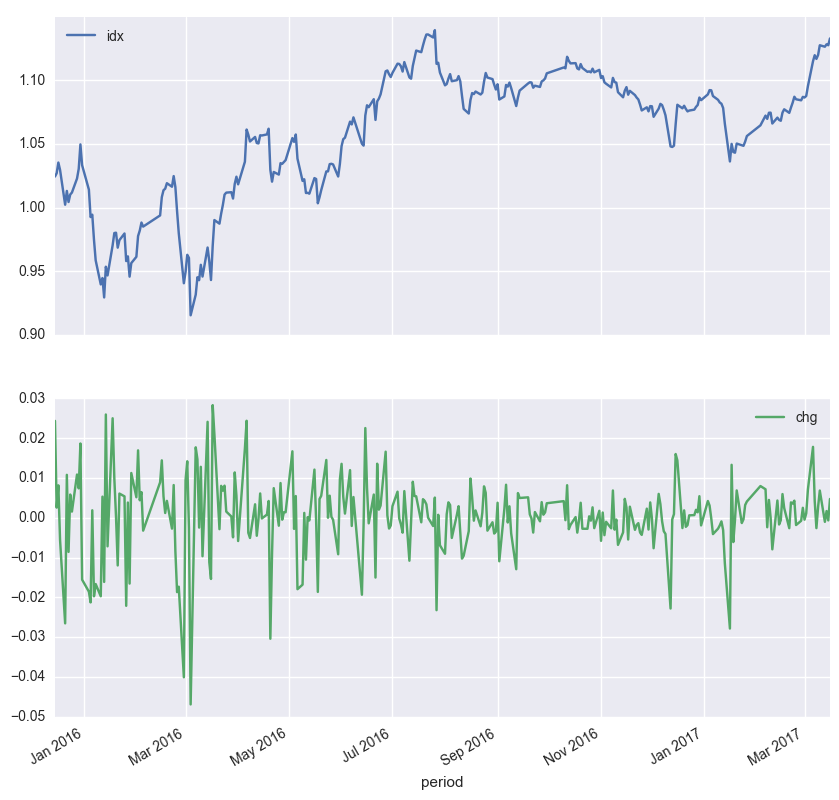

In [95]:
plots = df_sec_add_idx.loc[:, ['period', 'idx', 'chg']]\
    .set_index('period')\
    .plot(subplots=True, figsize=(10, 10))
plt.show()

In [101]:
df_sec_add_idx.loc[:, ['sec_code', 'idx', 'chg']]\
    .groupby('sec_code')\
    .agg(np.std)\
    .rename(columns={'idx': 'idx_std', 'chg': 'chg_std'})\
    .reset_index()

sec_code   idx_std   chg_std
0  400129776  0.050308  0.009641

In [110]:
(df_sec_add_idx.query('chg > 0.009641').shape,
 df_sec_add_idx.shape)

((33, 6), (305, 6))

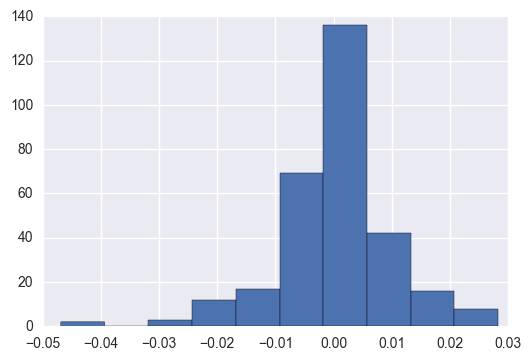

In [104]:
df_sec_add_idx.chg.hist()

In [103]:
df_sec_add_idx.chg.sort_values()[::-1][:20]

61     0.028324
21     0.025968
23     0.025020
74     0.024391
0      0.024363
58     0.024130
121    0.022557
62     0.021044
11     0.018679
296    0.017831
53     0.017716
73     0.017444
34     0.016954
92     0.016712
129    0.016618
245    0.016030
54     0.014689
106    0.014535
246    0.014442
39     0.014439
Name: chg, dtype: float64

* 指数的波动性是5.03%，涨幅的波动性是0.96%;
* 指数的每天涨幅的最大值为2.83%，最小值为-5%；
* **最终决定采用指数每日增幅的波动率的一个标准差**

## 4. 寻找上涨区间
* 涨幅大于1个标准差，约有10%的日期符合上涨条件；
* 上涨股票比例大于x%；
* 